In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%matplotlib inline
import torch
import numpy as np

In [41]:
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/train.txt", sep="\t", index_col=0)
test = pd.read_csv("/content/drive/MyDrive/test.txt", sep="\t", index_col=0)
valid = pd.read_csv("/content/drive/MyDrive/valid.txt", sep="\t", index_col=0)
test.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

knock80

In [42]:
from collections import defaultdict
import string
import re

def preprocess(text: str) -> str:
  text = re.sub(r'\s*\bNaN\b\s*', '', text)
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r'\s+', ' ', text).strip()
  return text

train["TITLE"] = train["TITLE"].apply(preprocess)
test["TITLE"] = test["TITLE"].apply(preprocess)
valid["TITLE"] = valid["TITLE"].apply(preprocess)

d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}

print(f'ID数: {len(set(word2id.values()))}\n')
print('頻度上位20語')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

def tokenizer(text, word2id=word2id, unk=0):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

ID数: 7771

頻度上位20語
to: 1
in: 2
the: 3
of: 4
for: 5
on: 6
as: 7
update: 8
us: 9
and: 10
a: 11
with: 12
at: 13
is: 14
after: 15
new: 16
says: 17
from: 18
by: 19
up: 20


knock81

In [43]:
from torch import nn
from torch.utils.data import Dataset

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:, -1, :])
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
    return hidden

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [44]:
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.1315, 0.3175, 0.3415, 0.2094]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2726, 0.1675, 0.3983, 0.1617]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3003, 0.2033, 0.3292, 0.1672]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1871, 0.2304, 0.2784, 0.3042]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3487, 0.2200, 0.1804, 0.2509]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3245, 0.2043, 0.2292, 0.2419]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1770, 0.3968, 0.2369, 0.1893]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1791, 0.3512, 0.2841, 0.1856]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2059, 0.1806, 0.4508, 0.1627]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2877, 0.1440, 0.3274, 0.2409]], grad_fn=<SoftmaxBackward0>)


knock82

In [45]:
from torch.utils.data import DataLoader
import time
from torch import optim
from matplotlib import pyplot as plt

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      outputs = model(inputs)
      if criterion != None:
        loss += criterion(outputs, labels).item()

      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  model.to(device)

  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    s_time = time.time()

    model.train()
    for data in dataloader_train:
      optimizer.zero_grad()

      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    model.eval()

    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

epoch: 1, loss_train: 1.1022, accuracy_train: 0.5258, loss_valid: 1.0938, accuracy_valid: 0.5180, 44.4769sec
epoch: 2, loss_train: 1.0120, accuracy_train: 0.5916, loss_valid: 1.0332, accuracy_valid: 0.5562, 44.4002sec
epoch: 3, loss_train: 0.8997, accuracy_train: 0.6594, loss_valid: 0.9726, accuracy_valid: 0.6297, 45.9624sec
epoch: 4, loss_train: 0.7209, accuracy_train: 0.7446, loss_valid: 0.8026, accuracy_valid: 0.7234, 43.7748sec
epoch: 5, loss_train: 0.6096, accuracy_train: 0.7834, loss_valid: 0.7303, accuracy_valid: 0.7511, 44.0318sec
epoch: 6, loss_train: 0.5597, accuracy_train: 0.8002, loss_valid: 0.7688, accuracy_valid: 0.7444, 43.7870sec
epoch: 7, loss_train: 0.4850, accuracy_train: 0.8285, loss_valid: 0.7005, accuracy_valid: 0.7594, 44.0048sec
epoch: 8, loss_train: 0.4539, accuracy_train: 0.8398, loss_valid: 0.6960, accuracy_valid: 0.7594, 43.2748sec
epoch: 9, loss_train: 0.4389, accuracy_train: 0.8444, loss_valid: 0.6909, accuracy_valid: 0.7616, 43.3792sec
epoch: 10, loss_tra

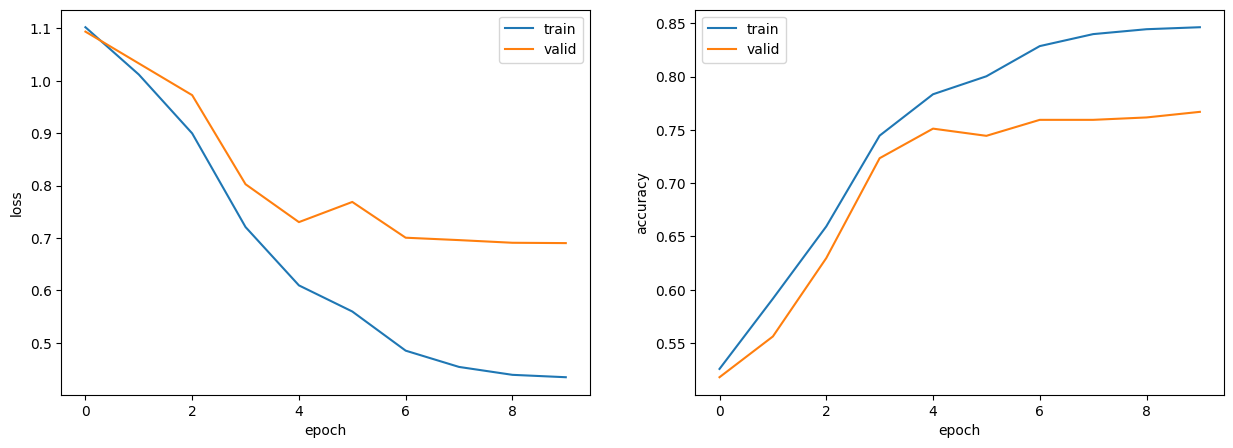

正解率（学習データ）：0.846
正解率（評価データ）：0.705


In [46]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

knock83

In [47]:
class Padsequence():
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

epoch: 1, loss_train: 1.2903, accuracy_train: 0.3987, loss_valid: 1.2629, accuracy_valid: 0.4250, 9.8408sec
epoch: 2, loss_train: 1.2091, accuracy_train: 0.4656, loss_valid: 1.1985, accuracy_valid: 0.4783, 9.1273sec
epoch: 3, loss_train: 1.0751, accuracy_train: 0.5884, loss_valid: 1.0855, accuracy_valid: 0.5907, 9.6347sec
epoch: 4, loss_train: 0.9999, accuracy_train: 0.6427, loss_valid: 1.0297, accuracy_valid: 0.6274, 9.8008sec
epoch: 5, loss_train: 0.8653, accuracy_train: 0.7254, loss_valid: 0.9093, accuracy_valid: 0.7001, 9.0030sec
epoch: 6, loss_train: 0.8694, accuracy_train: 0.7073, loss_valid: 0.9364, accuracy_valid: 0.6784, 9.7577sec
epoch: 7, loss_train: 0.8080, accuracy_train: 0.7347, loss_valid: 0.8846, accuracy_valid: 0.7054, 9.7266sec
epoch: 8, loss_train: 0.7548, accuracy_train: 0.7589, loss_valid: 0.8390, accuracy_valid: 0.7234, 9.9614sec
epoch: 9, loss_train: 0.7095, accuracy_train: 0.7716, loss_valid: 0.8086, accuracy_valid: 0.7399, 10.1404sec
epoch: 10, loss_train: 0.70

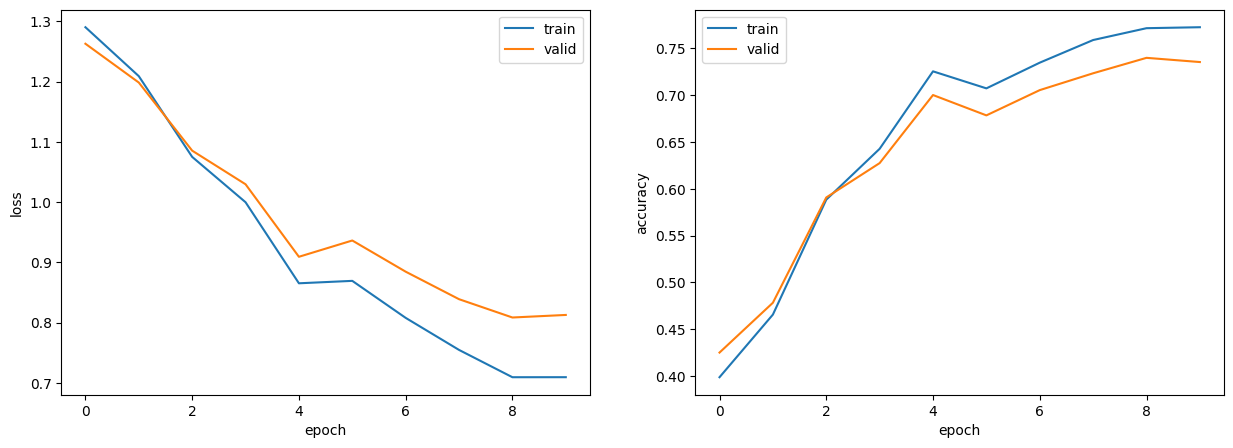

正解率（学習データ）：0.773
正解率（評価データ）：0.669


In [48]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

knock84

In [12]:
from gensim.models import KeyedVectors
model_GN = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [49]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model_GN[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 6713 / 7772
torch.Size([7772, 300])


In [50]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1
    if emb_weights != None:
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:, -1, :])
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
    return hidden

epoch: 1, loss_train: 1.1712, accuracy_train: 0.4427, loss_valid: 1.1587, accuracy_valid: 0.4573, 10.6626sec
epoch: 2, loss_train: 1.0821, accuracy_train: 0.5790, loss_valid: 1.0583, accuracy_valid: 0.6034, 10.3168sec
epoch: 3, loss_train: 1.0257, accuracy_train: 0.6162, loss_valid: 1.0101, accuracy_valid: 0.6327, 11.3672sec
epoch: 4, loss_train: 1.0758, accuracy_train: 0.5927, loss_valid: 1.0712, accuracy_valid: 0.5960, 9.7434sec
epoch: 5, loss_train: 0.9572, accuracy_train: 0.6648, loss_valid: 0.9544, accuracy_valid: 0.6672, 9.2404sec
epoch: 6, loss_train: 0.9371, accuracy_train: 0.6693, loss_valid: 0.9372, accuracy_valid: 0.6664, 9.4842sec
epoch: 7, loss_train: 1.1224, accuracy_train: 0.5839, loss_valid: 1.1482, accuracy_valid: 0.5742, 9.8499sec
epoch: 8, loss_train: 0.9384, accuracy_train: 0.6677, loss_valid: 0.9627, accuracy_valid: 0.6574, 9.7801sec
epoch: 9, loss_train: 0.9391, accuracy_train: 0.6669, loss_valid: 0.9492, accuracy_valid: 0.6619, 8.9644sec
epoch: 10, loss_train: 0.

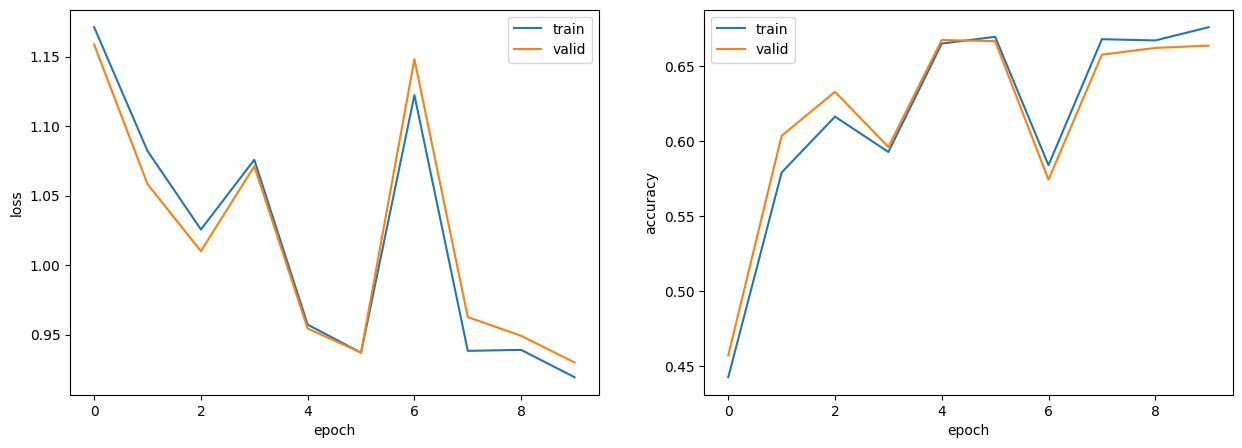

正解率（学習データ）：0.676
正解率（評価データ）：0.601


In [51]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

knock85

epoch: 1, loss_train: 1.2045, accuracy_train: 0.4136, loss_valid: 1.2090, accuracy_valid: 0.4423, 11.6531sec
epoch: 2, loss_train: 1.1086, accuracy_train: 0.5448, loss_valid: 1.1368, accuracy_valid: 0.5307, 11.7345sec
epoch: 3, loss_train: 1.0259, accuracy_train: 0.6198, loss_valid: 1.0324, accuracy_valid: 0.6169, 11.7340sec
epoch: 4, loss_train: 1.0295, accuracy_train: 0.6104, loss_valid: 1.0524, accuracy_valid: 0.5952, 10.2912sec
epoch: 5, loss_train: 1.0155, accuracy_train: 0.6258, loss_valid: 1.0455, accuracy_valid: 0.6139, 11.8418sec
epoch: 6, loss_train: 1.0690, accuracy_train: 0.6080, loss_valid: 1.1124, accuracy_valid: 0.5802, 12.2787sec
epoch: 7, loss_train: 1.0012, accuracy_train: 0.6335, loss_valid: 1.0504, accuracy_valid: 0.6132, 14.0747sec
epoch: 8, loss_train: 0.9967, accuracy_train: 0.6347, loss_valid: 1.0365, accuracy_valid: 0.6184, 12.6191sec
epoch: 9, loss_train: 1.0186, accuracy_train: 0.6235, loss_valid: 1.0543, accuracy_valid: 0.6072, 10.7176sec
epoch: 10, loss_tra

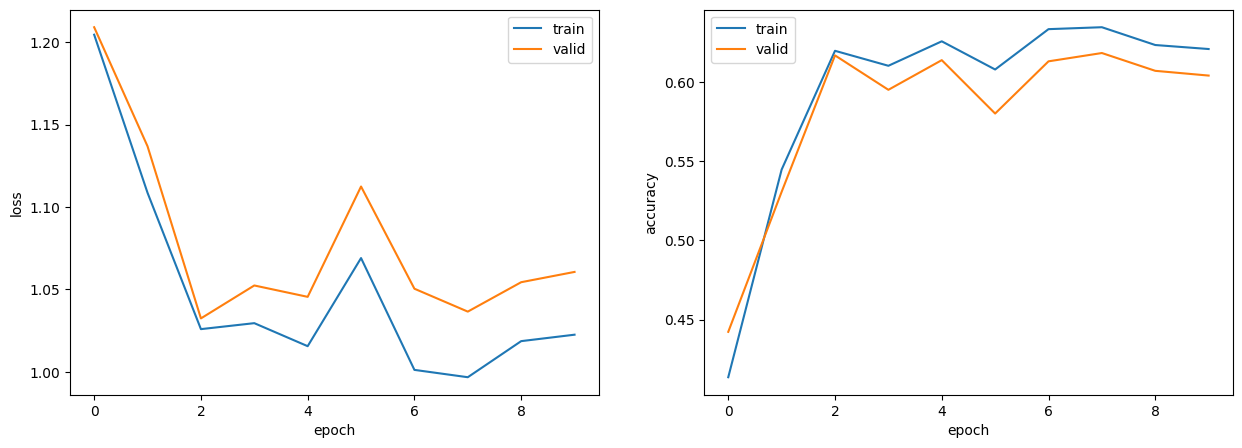

正解率（学習データ）：0.621
正解率（評価データ）：0.530


In [52]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

knock86

In [53]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    emb = self.emb(x).unsqueeze(1)
    conv = self.conv(emb)
    act = F.relu(conv.squeeze(3))
    max_pool = F.max_pool1d(act, act.size()[2])
    out = self.fc(self.drop(max_pool.squeeze(2)))
    return out

In [19]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2615, 0.2299, 0.2320, 0.2766]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2147, 0.2400, 0.2691, 0.2763]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2607, 0.2054, 0.2509, 0.2830]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2470, 0.2617, 0.2200, 0.2713]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2713, 0.2319, 0.1926, 0.3043]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2229, 0.2281, 0.2505, 0.2986]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2446, 0.2251, 0.2517, 0.2786]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2339, 0.2273, 0.2372, 0.3016]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2587, 0.2414, 0.2421, 0.2578]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2454, 0.2812, 0.2126, 0.2608]], grad_fn=<SoftmaxBackward0>)


knock87

epoch: 1, loss_train: 1.0456, accuracy_train: 0.5994, loss_valid: 1.0266, accuracy_valid: 0.6004, 8.9902sec
epoch: 2, loss_train: 0.9751, accuracy_train: 0.6272, loss_valid: 0.9698, accuracy_valid: 0.6124, 8.5277sec
epoch: 3, loss_train: 0.9051, accuracy_train: 0.6799, loss_valid: 0.9179, accuracy_valid: 0.6747, 8.7093sec
epoch: 4, loss_train: 0.8497, accuracy_train: 0.7028, loss_valid: 0.8814, accuracy_valid: 0.6904, 9.0095sec
epoch: 5, loss_train: 0.8049, accuracy_train: 0.7197, loss_valid: 0.8434, accuracy_valid: 0.6934, 13.5770sec
epoch: 6, loss_train: 0.7727, accuracy_train: 0.7289, loss_valid: 0.8241, accuracy_valid: 0.7039, 8.7127sec
epoch: 7, loss_train: 0.7517, accuracy_train: 0.7366, loss_valid: 0.8116, accuracy_valid: 0.7076, 9.0485sec
epoch: 8, loss_train: 0.7373, accuracy_train: 0.7418, loss_valid: 0.8044, accuracy_valid: 0.7099, 11.3136sec
epoch: 9, loss_train: 0.7312, accuracy_train: 0.7447, loss_valid: 0.8010, accuracy_valid: 0.7054, 11.7471sec
epoch: 10, loss_train: 0.

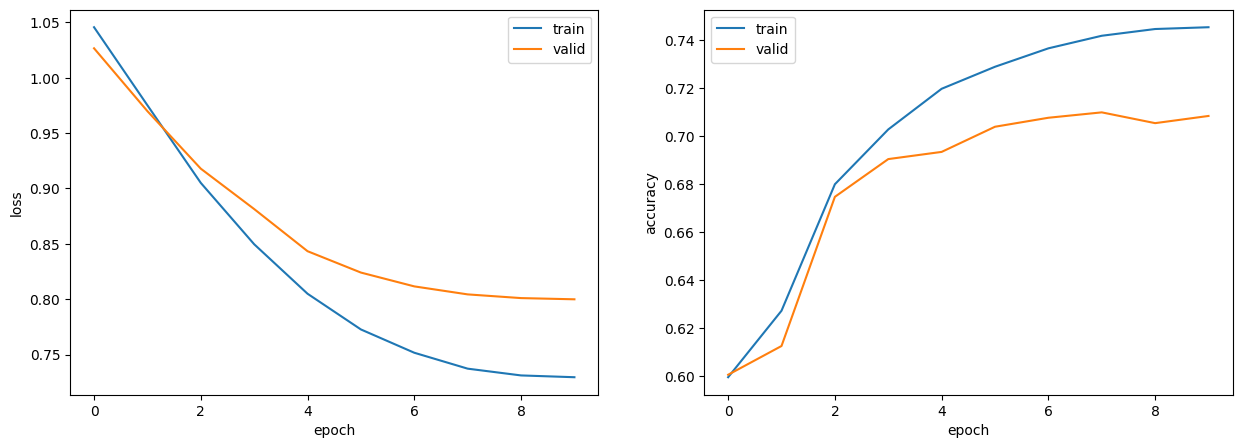

正解率（学習データ）：0.745
正解率（評価データ）：0.642


In [54]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

knock88

In [55]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    emb = self.emb(x).unsqueeze(1)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    max_pool_cat = torch.cat(max_pool, 1)
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    return out

In [22]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.4 MB/s eta 0:00:00


In [56]:
def objective(trial):
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  model = textCNN(VOCAB_SIZE, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  device = torch.cuda.set_device(0)

  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)

  return loss_valid

In [58]:
study = optuna.create_study()
study.optimize(objective, timeout=7200)

print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2023-07-10 07:26:25,472] A new study created in memory with name: no-name-2df4f6df-767e-434d-a5d0-0021b8a0a288
<ipython-input-56-b80af22bcb9f>:2: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
<ipython-input-56-b80af22bcb9f>:3: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
<ipython-input-56-b80af22bcb9f>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...)

epoch: 1, loss_train: 0.8992, accuracy_train: 0.6703, loss_valid: 0.9139, accuracy_valid: 0.6567, 20.8920sec
epoch: 2, loss_train: 0.6976, accuracy_train: 0.7523, loss_valid: 0.7869, accuracy_valid: 0.7211, 22.7149sec
epoch: 3, loss_train: 0.5454, accuracy_train: 0.8045, loss_valid: 0.7001, accuracy_valid: 0.7436, 20.5697sec
epoch: 4, loss_train: 0.4128, accuracy_train: 0.8726, loss_valid: 0.6671, accuracy_valid: 0.7744, 22.3149sec
epoch: 5, loss_train: 0.3434, accuracy_train: 0.8939, loss_valid: 0.6321, accuracy_valid: 0.7706, 21.5315sec
epoch: 6, loss_train: 0.2545, accuracy_train: 0.9328, loss_valid: 0.5974, accuracy_valid: 0.7849, 22.1753sec
epoch: 7, loss_train: 0.2007, accuracy_train: 0.9532, loss_valid: 0.6067, accuracy_valid: 0.7789, 20.6248sec
epoch: 8, loss_train: 0.1634, accuracy_train: 0.9641, loss_valid: 0.5843, accuracy_valid: 0.7834, 23.4487sec
epoch: 9, loss_train: 0.1364, accuracy_train: 0.9702, loss_valid: 0.5745, accuracy_valid: 0.7894, 21.8746sec
epoch: 10, loss_tra

[I 2023-07-10 07:32:18,313] Trial 0 finished with value: 0.5996955076952718 and parameters: {'emb_size': 300.0, 'out_channels': 50.0, 'drop_rate': 0.4, 'learning_rate': 0.009137227408741, 'momentum': 0.9, 'batch_size': 32.0}. Best is trial 0 with value: 0.5996955076952718.
[W 2023-07-10 07:32:19,341] Trial 1 failed with parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.5, 'learning_rate': 0.010030052783936344, 'momentum': 0.7, 'batch_size': 64.0} because of the following error: RuntimeError('max_pool1d: Expected 2D or 3D (batch mode) tensor with optional 0 dim batch size for input, but got:[64, 200, 14, 101]').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-56-b80af22bcb9f>", line 22, in objective
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(

RuntimeError: ignored

In [59]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 30

model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

device = torch.cuda.set_device(0)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

NameError: ignored

knock89

In [60]:
!pip install transformers
from transformers import BertTokenizer, BertModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ids: tensor([  101,  2885,  6561, 24514,  2391,  2006,  8169,  2586,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels: tensor([1., 0., 0., 0.])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, loss_train: 0.0935, accuracy_train: 0.9472, loss_valid: 0.1066, accuracy_valid: 0.9385, 80.5781sec
epoch: 2, loss_train: 0.0471, accuracy_train: 0.9758, loss_valid: 0.0928, accuracy_valid: 0.9378, 67.4707sec
epoch: 3, loss_train: 0.0279, accuracy_train: 0.9863, loss_valid: 0.0937, accuracy_valid: 0.9430, 67.5330sec
epoch: 4, loss_train: 0.0240, accuracy_train: 0.9865, loss_valid: 0.1137, accuracy_valid: 0.9235, 69.3900sec


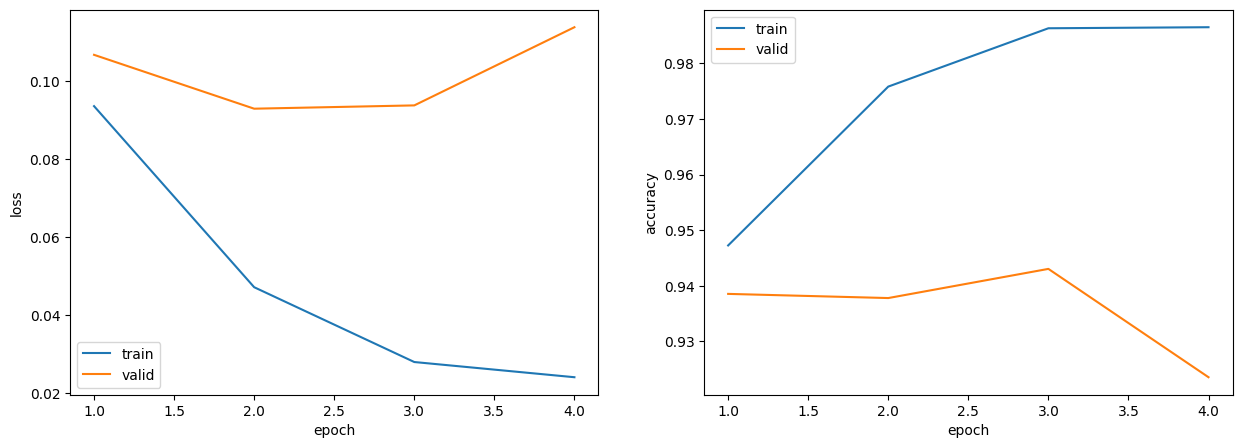

正解率（学習データ）：0.987
正解率（検証データ）：0.924
正解率（評価データ）：0.884


In [61]:
from torch import cuda

class NewsDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      outputs = model(ids, mask)
      loss += criterion(outputs, labels).item()

      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  model.to(device)

  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    s_time = time.time()

    model.train()
    for data in dataloader_train:
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      optimizer.zero_grad()

      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

def calculate_accuracy(model, dataset, device):
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total


y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

model = BERTClass(DROP_RATE, OUTPUT_SIZE)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

device = 'cuda' if cuda.is_available() else 'cpu'

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')